In [1]:
from pauliopt.clifford.tableau import CliffordTableau
import qiskit
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Clifford Tableau Synthesis
This is an outline of our work: *Architecture-Aware Synthesis of Stabilizer Circuits from Clifford Tableaus* (arxiv: 2309.08972). 


## Clifford Tableaus

Clifford tableaus are a compact way to represent quantum states and operations in the stabilizer formalism, which is a subset of all quantum operations that can be efficiently simulated classically. These tableaus are particularly useful in the study and simulation of quantum error-correcting codes and certain quantum algorithms.

In the stabilizer formalism, the state of a quantum system is described by a set of stabilizer generators, which are Pauli operators (combinations of I, X, Y, and Z) that leave the state invariant. Similarly, destabilizer states are those not stabilized by the set of generators, offering a complete description of the system.

A Clifford tableau is a binary matrix representation of these stabilizer and destabilizer states. Each row represents a stabilizer or destabilizer generator, and the columns correspond to the qubits and the Pauli operators acting on them. The tableau allows for efficient computation of the evolution of stabilizer states under Clifford operations (like CNOT-, H-, and S-gates) which are central to quantum error correction and fault-tolerant quantum computing.

In Pauliopt a Clifford Tableau can be constructed as follows:

In [2]:
ct = CliffordTableau(5)

print(ct)

X/Z I/I I/I I/I I/I | + 
I/I X/Z I/I I/I I/I | + 
I/I I/I X/Z I/I I/I | + 
I/I I/I I/I X/Z I/I | + 
I/I I/I I/I I/I X/Z | + 



You can append/prepend H, S and CNOT operations:

In [3]:
ct.append_h(0)

print(ct)

Z/X I/I I/I I/I I/I | + 
I/I X/Z I/I I/I I/I | + 
I/I I/I X/Z I/I I/I | + 
I/I I/I I/I X/Z I/I | + 
I/I I/I I/I I/I X/Z | + 



In [4]:
ct.prepend_cnot(0, 1)

print(ct)

Z/X X/I I/I I/I I/I | + 
I/X X/Z I/I I/I I/I | + 
I/I I/I X/Z I/I I/I | + 
I/I I/I I/I X/Z I/I | + 
I/I I/I I/I I/I X/Z | + 



In [5]:
ct.prepend_s(0)

print(ct)

Y/X X/I I/I I/I I/I | - 
I/X X/Z I/I I/I I/I | + 
I/I I/I X/Z I/I I/I | + 
I/I I/I I/I X/Z I/I | + 
I/I I/I I/I I/I X/Z | + 



Internally the tableau is stored in a $2n \times 2n$ binary matrix, which records the appending/prepending operations according to [1].

In [6]:
ct.tableau

array([[1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [7]:
ct.signs

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

## Clifford Tableau Synthesis

Given now such a random clifford tableau (we will create it from a random clifford circuit) and a device connectivity (let's take a line graph for instance). You can synthesize the tableau to a circuit following the device constrains.

Let's generate a random clifford circuit using qiskit:

In [8]:
def tableau_from_circuit(tableau, circ):
    qreg = circ.qregs[0]
    circ = transpile(circ, basis_gates=["h", "s", "cx"])
    for op in circ:
        if op.operation.name == "h":
            tableau.append_h(qreg.index(op.qubits[0]))
        elif op.operation.name == "s":
            tableau.append_s(qreg.index(op.qubits[0]))
        elif op.operation.name == "cx":
            tableau.append_cnot(qreg.index(op.qubits[0]), qreg.index(op.qubits[1]))
        else:
            raise TypeError(
                f"Unrecongnized Gate type: {op.operation.name} for Clifford Tableaus")
    return tableau


In [9]:
n_qubits = 5

tableau = qiskit.quantum_info.random_clifford(n_qubits, seed=42)

ct = CliffordTableau(n_qubits)
ct = tableau_from_circuit(ct, tableau.to_circuit())
print(ct)

Z/I X/X I/Z Z/X X/I | + 
X/X X/Z Y/Z Y/Z I/I | - 
I/I Y/X X/X I/Z Y/I | - 
Z/Z Y/Z Z/I Z/Y Z/X | + 
Y/X Y/I X/I X/I Y/Y | + 



Now let's assume that there exists a quantum device with a line connectivity.

In [10]:
from pauliopt.topologies import Topology

topo = Topology.line(n_qubits)

topo

Topology(5, [{3, 4}, {0, 1}, {2, 3}, {1, 2}])

The standard (highly simplified process !!) in a compilation framework is now to first optimize the clifford tableau and then route it to the specific qubit device.

Let's do that using qiskit:

In [11]:
couplings = [[i, j] for i, j in topo.couplings]
print(couplings)

inital_circuit = tableau.to_circuit()
qc = transpile(inital_circuit, 
               basis_gates=["h", "s", "cx"],                                       
               coupling_map=couplings,                      
               routing_method="sabre",                      
               initial_layout=[i for i in range(n_qubits)])

print(qc)
print("Operations: ", qc.count_ops())
print("Depth: ", qc.depth())

[[3, 4], [0, 1], [2, 3], [1, 2]]
         ┌───┐┌───┐     ┌───┐     ┌───┐     ┌───┐     ┌───┐                    »
q_0 -> 0 ┤ H ├┤ H ├──■──┤ H ├──■──┤ H ├──■──┤ H ├──■──┤ H ├────────────────────»
         ├───┤├───┤┌─┴─┐├───┤┌─┴─┐├───┤┌─┴─┐├───┤┌─┴─┐├───┤                    »
q_1 -> 1 ┤ S ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├────────────────────»
         ├───┤└───┘└───┘└───┘├───┤├───┤├───┤├───┤└───┘├───┤     ┌───┐     ┌───┐»
q_2 -> 2 ┤ H ├────────────■──┤ H ├┤ S ├┤ H ├┤ S ├──■──┤ H ├──■──┤ H ├──■──┤ H ├»
         ├───┤┌───┐┌───┐┌─┴─┐├───┤├───┤└───┘├───┤┌─┴─┐├───┤┌─┴─┐├───┤┌─┴─┐└───┘»
q_3 -> 3 ┤ H ├┤ S ├┤ H ├┤ X ├┤ H ├┤ H ├──■──┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├──■──»
         ├───┤└───┘└───┘└───┘└───┘└───┘┌─┴─┐├───┤├───┤└───┘└───┘└───┘└───┘┌─┴─┐»
q_4 -> 4 ┤ H ├─────────────────────────┤ X ├┤ H ├┤ H ├────────────────────┤ X ├»
         └───┘                         └───┘└───┘└───┘                    └───┘»
«                                  ┌───┐┌───┐     ┌───┐     ┌───┐          »

In pauliopt you can achieve architecture-aware synthesis by using the `synthesize_tableau` method:

In [12]:
from pauliopt.clifford.tableau_synthesis import synthesize_tableau

In [13]:
qc_po, _ = synthesize_tableau(ct, topo, include_swaps=False)
qc_po = qc_po.to_qiskit()

print(qc_po)
print("Operations: ", qc_po.count_ops())
print("Depth: ", qc_po.depth())

     ┌───┐                                             ┌───┐               »
q_0: ┤ X ├──■──────────────────────────────────────────┤ X ├───────■───────»
     └─┬─┘┌─┴─┐                                   ┌───┐└─┬─┘     ┌─┴─┐┌───┐»
q_1: ──■──┤ X ├───────■───────────────────────────┤ X ├──■────■──┤ X ├┤ H ├»
     ┌───┐├───┤┌───┐┌─┴─┐                    ┌───┐└─┬─┘     ┌─┴─┐├───┤└───┘»
q_2: ┤ H ├┤ X ├┤ H ├┤ X ├───────■────────────┤ X ├──■────■──┤ X ├┤ X ├──■──»
     ├───┤└─┬─┘├───┤├───┤┌───┐┌─┴─┐     ┌───┐└─┬─┘     ┌─┴─┐├───┤└─┬─┘┌─┴─┐»
q_3: ┤ H ├──■──┤ X ├┤ S ├┤ H ├┤ X ├──■──┤ H ├──■───────┤ X ├┤ H ├──■──┤ X ├»
     ├───┤     └─┬─┘├───┤├───┤├───┤┌─┴─┐└───┘          └───┘└───┘     └───┘»
q_4: ┤ S ├───────■──┤ S ├┤ H ├┤ S ├┤ X ├───────────────────────────────────»
     └───┘          └───┘└───┘└───┘└───┘                                   »
«     ┌───┐                                                                 »
«q_0: ┤ X ├────────────────────────────────────────────────────────────────

In [14]:
print("Circuits Match: ", Operator.from_circuit(qc_po).equiv(Operator.from_circuit(inital_circuit)))

Circuits Match:  True


We can see that this clearly improves the performance of a sampling a random clifford operator

## Initial and final placement

You can additionally let the algorithm select a initial and final placement for you (which will typically decrease the CNOT-count further)

In [15]:
qc_po, _ = synthesize_tableau(ct, topo, include_swaps=True)
qc_po = qc_po.to_qiskit()

print(qc_po)
print(qc_po.count_ops())


                    ┌───┐                    ┌───┐     ┌───┐┌───┐          »
q_0: ────────────■──┤ X ├───────■────────────┤ X ├──■──┤ S ├┤ X ├──────────»
     ┌───┐       │  └─┬─┘┌───┐  │  ┌───┐     └─┬─┘┌─┴─┐└───┘└─┬─┘┌───┐     »
q_1: ┤ S ├──■────┼────■──┤ X ├──┼──┤ H ├───────┼──┤ X ├──■────┼──┤ H ├─────»
     └───┘┌─┴─┐  │       └─┬─┘  │  ├───┤┌───┐  │  ├───┤┌─┴─┐  │  ├───┤┌───┐»
q_2: ─────┤ X ├──┼─────────■────┼──┤ S ├┤ H ├──┼──┤ S ├┤ X ├──┼──┤ H ├┤ S ├»
     ┌───┐└───┘┌─┴─┐          ┌─┴─┐├───┤└───┘  │  └───┘└───┘  │  ├───┤├───┤»
q_3: ┤ H ├─────┤ X ├──■───────┤ X ├┤ X ├───────■────■─────────■──┤ X ├┤ H ├»
     └───┘     └───┘┌─┴─┐     └───┘└─┬─┘          ┌─┴─┐          └─┬─┘└───┘»
q_4: ───────────────┤ X ├────────────■────────────┤ X ├────────────■───────»
                    └───┘                         └───┘                    »
«               ┌───┐          ┌───┐┌───┐               ┌───┐┌───┐┌───┐     »
«q_0: ───────■──┤ S ├──■───────┤ X ├┤ X ├────────────■──┤ X ├┤ S ├┤ H ├────

## Experiments in arxiv: 2309.08972

To verify our results we conducted a numerical study evaluating our algorithm against the typical used IBM Backends (2022).

Let's just repeat this study for `IBM_Guadalupe`

In [16]:
def random_clifford_circuit(nr_gates=20, nr_qubits=4, gate_choice=None):
    qc = QuantumCircuit(nr_qubits)
    if gate_choice is None:
        gate_choice = ["CY", "CZ", "CX", "H", "S", "V"]
    for _ in range(nr_gates):
        gate_t = np.random.choice(gate_choice)
        if gate_t == "CX":
            control = np.random.choice([i for i in range(nr_qubits)])
            target = np.random.choice([i for i in range(nr_qubits) if i != control])
            qc.cx(control, target)
        elif gate_t == "CY":
            control = np.random.choice([i for i in range(nr_qubits)])
            target = np.random.choice([i for i in range(nr_qubits) if i != control])
            qc.cy(control, target)
        elif gate_t == "CZ":
            control = np.random.choice([i for i in range(nr_qubits)])
            target = np.random.choice([i for i in range(nr_qubits) if i != control])
            qc.cz(control, target)
        elif gate_t == "H":
            qubit = np.random.choice([i for i in range(nr_qubits)])
            qc.h(qubit)
        elif gate_t == "S":
            qubit = np.random.choice([i for i in range(nr_qubits)])
            qc.s(qubit)
        elif gate_t == "V":
            qubit = np.random.choice([i for i in range(nr_qubits)])
            qc.sx(qubit)
        elif gate_t == "CX":
            control = np.random.choice([i for i in range(nr_qubits)])
            target = np.random.choice([i for i in range(nr_qubits) if i != control])
            qc.cx(control, target)
    return qc


def random_hscx_circuit(nr_gates=20, nr_qubits=4):
    gate_choice = ["CX", "H", "S"]
    return random_clifford_circuit(nr_gates=nr_gates,
                                   nr_qubits=nr_qubits,
                                   gate_choice=gate_choice)

def get_ops_count(qc: QuantumCircuit):
    count = {"h": 0, "cx": 0, "s": 0, "depth": qc.depth()}
    ops = qc.count_ops()
    if "cx" in ops.keys():
        count["cx"] += ops['cx']
    if "h" in ops.keys():
        count["h"] += ops["h"]
    if "s" in ops.keys():
        count["s"] += ops["s"]
    return count


def our_compilation(circ: QuantumCircuit, topology):
    ct = CliffordTableau(circ.num_qubits)
    ct = tableau_from_circuit(ct, circ)
    circ_out, _ = synthesize_tableau(ct, topo, include_swaps=True)
    circ_out = circ_out.to_qiskit()
    column = get_ops_count(circ_out)
    return column

def qiskit_compilation(circ: QuantumCircuit, topology):
    couplings = [[i, j] for i, j in topo.couplings]
    qc = qiskit.quantum_info.Clifford(circ).to_circuit()
    circ_out = transpile(qc, 
               basis_gates=["h", "s", "cx"],                                       
               coupling_map=couplings,                      
               routing_method="sabre")

    column = get_ops_count(circ_out)
    return column

In [17]:
# see our paper for an outline of all connectivity graphs.
guadalupe_connectivity = [[0, 1], [1, 0], [1, 2], [1, 4], [2, 1], [2, 3], [3, 2], [3, 5], [4, 1], [4, 7], [5, 3], [5, 8], [6, 7], [7, 4], [7, 6], [7, 10], [8, 5], [8, 9], [8, 11], [9, 8], [10, 7], [10, 12], [11, 8], [11, 14], [12, 10], [12, 13], [12, 15], [13, 12], [13, 14], [14, 11], [14, 13], [15, 12]]

topo = Topology.from_dict({
    "num_qubits": 16,
    "couplings": guadalupe_connectivity})

In [18]:
df = pd.DataFrame(columns=["n_rep", "nr_gates", "method", "h", "s", "cx", "depth"])

for num_gates in range(1, 400, 40):
    for _ in range(20):
        circ = random_hscx_circuit(nr_qubits=topo.num_qubits, nr_gates=num_gates)

        column = {"n_rep": _, "nr_gates": num_gates, "method": "ours"} | our_compilation(circ, topo)

        df.loc[len(df)] = column

        column = {"n_rep": _, "nr_gates": num_gates, "method": "qiskit"} | qiskit_compilation(circ, topo)

        df.loc[len(df)] = column


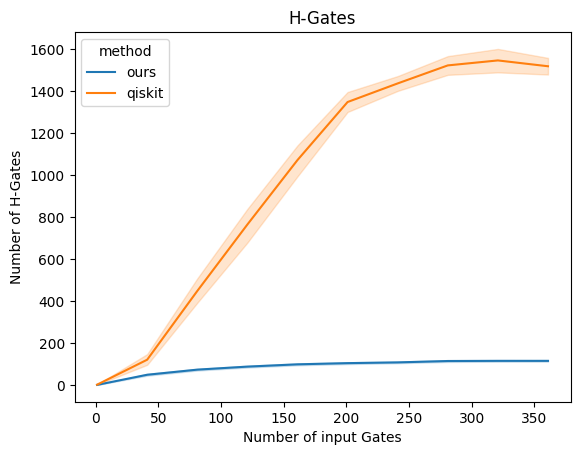

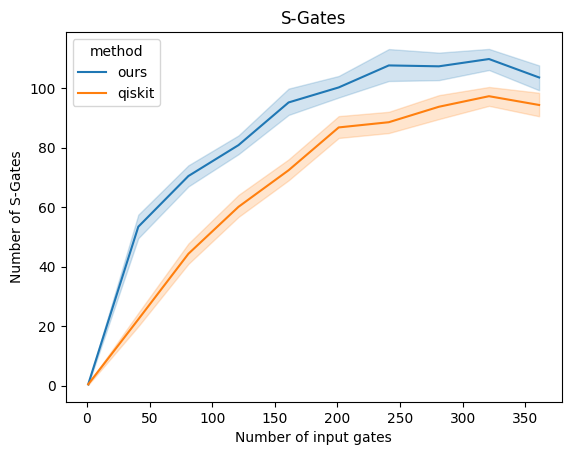

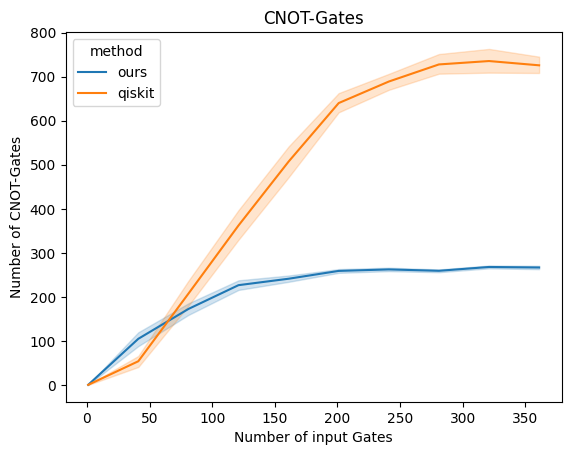

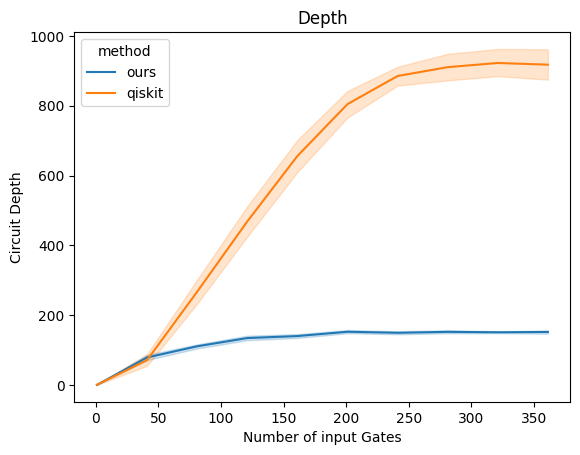

In [19]:
sns.lineplot(df, x="nr_gates", y="h", hue="method")
plt.title("H-Gates")
plt.xlabel("Number of input Gates")
plt.ylabel("Number of H-Gates")
plt.show()

sns.lineplot(df, x="nr_gates", y="s", hue="method")
plt.title("S-Gates")
plt.xlabel("Number of input gates")
plt.ylabel("Number of S-Gates")
plt.show()

sns.lineplot(df, x="nr_gates", y="cx", hue="method")
plt.title("CNOT-Gates")
plt.xlabel("Number of input Gates")
plt.ylabel("Number of CNOT-Gates")
plt.show()

sns.lineplot(df, x="nr_gates", y="depth", hue="method")
plt.title("Depth")
plt.xlabel("Number of input Gates")
plt.ylabel("Circuit Depth")
plt.show()


We can see that on average we can improve the CNOT count. 

Nevertheless there is quite some room for improvement, since we converge fast to the asymptotic upperbound of $\mathcal{O}(n^2)$ in terms of H, S and CNOT-Gates,

Note that this is just a outline of our experiments. 
For a complete implementation, see: https://github.com/daehiff/pauliopt/blob/dev/experiments/clifford_experiment.py 